## Video Vision Transformer

In [73]:
import cv2
import os
import math
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
keras.utils.set_random_seed(42)
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True) 

from tensorflow.keras.models import Model
from sklearn.manifold import (TSNE)
from sklearn.metrics import roc_curve, auc
# os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

## Parameters

In [74]:
# `##` --> Adjustable

# DATA
IMG_SIZE = 128  ## Image size (128, 128) in this case
CHAN_SIZE = 1   # 1-GrayScale; 3-RGB
BATCH_SIZE = 8  ## 16, 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2  # 1-Crash; 0-Normal

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
# EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8,8,8) ##
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64   ## Size of the feature vectors transformed from the input
NUM_HEADS =  6   ##
NUM_LAYERS = 6   ##

## 111 Retrieve videos for training, validating, and testing

In [75]:
# retrieve all video name

frames_path = 'data/frames/'
frames_path_normal = 'data/frames/Normal/'
frames_path_crash = 'data/frames/Crash/'

frames_name_normal = sorted([f for f in os.listdir(frames_path_normal)])
frames_name_crash = sorted([f for f in os.listdir(frames_path_crash)])

In [76]:
#how many data needed
num_normal = 50
num_crash = 50

frames_name_normal = random.sample(frames_name_normal, num_normal)
frames_name_crash = random.sample(frames_name_crash, num_crash)

In [77]:
# 6:2:2.5 train test split

train_normal, test_normal = train_test_split(frames_name_normal,test_size=0.3, random_state=42)
train_crash, test_crash = train_test_split(frames_name_crash, test_size=0.3, random_state=42)

temporary_normal, test_normal = train_test_split(frames_name_normal, test_size=0.2, random_state=42)
temporary_crash, test_crash = train_test_split(frames_name_crash, test_size=0.2, random_state=42)

train_normal, val_normal = train_test_split(temporary_normal, test_size=0.25, random_state=42)
train_crash, val_crash = train_test_split(temporary_crash, test_size=0.25, random_state=42)

In [78]:
print("Normal Training Videos:", train_normal)
print()
print("Crash Training Videos:", train_crash)
print()
print("Normal Validation Videos:", val_normal)
print()
print("Crash Validation Videos:", val_crash)
print()
print("Normal Test Videos:", test_normal)
print()
print("Crash Test Videos:", test_crash)

Normal Training Videos: ['000103', '000384', '002860', '000815', '000109', '002473', '001719', '002299', '001729', '000178', '000572', '000896', '001004', '001379', '002419', '001139', '000357', '000380', '002772', '000420', '000457', '002070', '002234', '001394', '000654', '001840', '001409', '001140', '002933', '000903']

Crash Training Videos: ['001099', '000094', '001400', '000779', '000477', '001311', '000334', '000207', '000394', '001141', '001131', '001355', '000776', '001094', '001183', '001248', '000741', '000502', '001288', '000601', '000941', '000593', '001267', '000147', '001438', '000728', '000553', '001373', '000570', '000759']

Normal Validation Videos: ['000915', '000397', '002620', '001557', '001127', '002662', '000123', '001732', '000637', '000419']

Crash Validation Videos: ['000162', '000947', '001495', '000335', '000256', '000929', '000143', '001328', '001301', '001494']

Normal Test Videos: ['000131', '000882', '002414', '001471', '000953', '001084', '002233', '00

## Data Preprocessing

In [79]:
# Transform image to matrix format

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=CHAN_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # Normalization
    return image

train_videos = []
test_videos = []
train_labels = []
test_labels = []

for t in train_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(0)
    
for t in test_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(0)

for t in train_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(1)
    
for t in test_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(1)

train_videos = np.asarray(train_videos)
test_videos = np.asarray(test_videos)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

valid_videos = []
valid_labels = []
    
for t in val_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(1)

for t in val_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(0)

valid_videos = np.asarray(valid_videos)
valid_labels = np.asarray(valid_labels)

In [80]:
# Create Dataloader

def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")

# Create Embedding Mechanism

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        
        # `projected_patches`
        # dividing the input into patches (determined by kernel_size and strides) 
        # and transforming each patch into an 64-dimensional embedding.
        
        projected_patches = self.projection(videos) 
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

# Create Positional Mechanism

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## 111 Run Model

In [81]:
""" REFERENCE

IMG_SIZE = 128
CHAN_SIZE = 1
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

PATCH_SIZE = (8,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64
NUM_HEADS =  6
NUM_LAYERS = 6

"""

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape) # shape=(50,128,128,1)
    # Create patches
    patches = tubelet_embedder(inputs)
    # Encode patches
    encoded_patches = positional_encoder(patches)

    for _ in range(transformer_layers):
        
        # 1. Layer normalization and MultiHeadAttention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # 2. The MultiHeadAttention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        # 3. Skip connection - Add output from dense layers to earlier layer normalization
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # 4. Layer Normalization and MultiLayerPerception
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # 5. The two fully-connected layers with GELU activation functions
        x4 = layers.Dropout(0.1)(layers.Dense(units=embed_dim, activation='gelu')(x3))
        x5 = layers.Dropout(0.1)(layers.Dense(units=embed_dim, activation='gelu')(x4))
        
        # 6. Skip connection - Add output from dense layers to earlier layer normalization
        encoded_patches = layers.Add()([x5, x2])

    # Layer normalization and Global average pooling
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [82]:
def run_experiment(callback=None):
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=EMBED_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=EMBED_DIM)
    )

    # Compile the model with the optimizer, loss function and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model
    # You may definn the epochs here
    print("Callbacks being passed to model.fit():", callback)
    if (callback != None):
        history = model.fit(trainloader, epochs=5, validation_data=validloader)
    else:
        history = model.fit(trainloader, epochs=5, validation_data=validloader, callbacks=callback)

    return model, history

model, history = run_experiment()

Callbacks being passed to model.fit(): None
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 94s 11s/step - accuracy: 0.7388 - loss: 0.9468 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6920 - val_top-5-accuracy: 1.0000
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 90s 11s/step - accuracy: 0.7852 - loss: 0.5949 - top-5-accuracy: 1.0000 - val_accuracy: 0.5500 - val_loss: 0.7346 - val_top-5-accuracy: 1.0000
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 11s/step - accuracy: 0.3423 - loss: 0.8312 - top-5-accuracy: 1.0000 - val_accuracy: 0.6000 - val_loss: 0.6445 - val_top-5-accuracy: 1.0000
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - accuracy: 0.5775 - loss: 0.6886 - top-5-accuracy: 1.0000 - val_accuracy: 0.6500 - val_loss: 0.6039 - val_top-5-accuracy: 1.0000
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 11s/step - accuracy: 0.5881 - loss: 0.6381 - top-5-accuracy: 1.0000 - val_accuracy: 0.6500 - val_loss: 0.5913 - val_top-5-accuracy: 1.0000


In [83]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tubelet_embedding_4 │ (None, 1536, 64)  │     32,832 │ input_layer_4[0]… │
│ (TubeletEmbedding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoder… │ (None, 1536, 64)  │     98,304 │ tubelet_embeddin… │
│ (PositionalEncoder) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1536, 64)  │     15,604 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 1536, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1536, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 1536, 64)  │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 1536, 64)  │      4,160 │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 1536, 64)  │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 1536, 64)  │          0 │ dropout_57[0][0], │
│                     │                   │            │ add_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1536, 64)  │     15,604 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 1536, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_37[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_38[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1536, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 1536, 64)  │          0 │ dense_41[0][0]  

 Total params: 829,424 (3.16 MB)

 Trainable params: 276,474 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,950 (2.11 MB)

## Visualization

Specific on how many feature using, on which layer, we would provide such visualizations.
1. Model Evaluation
    1. Model accuracy & loss
    2. ROC Curves and AUC 
2. Model Analysis
    1. Confusion Matrix
    2. Feature analysis
        1. Weight Histograms
        2. LIME explainer
        3. Model performance on specific features
        4. t-SNE or PCA of Layer Activations（目前做的是2个dimensions）
        5. Layer Weight and Activation Animations(Processing)（设想的是每一个epoch都有一个heatmap of features weights,点击begin的时候heatmap会从epoch1对应的开始变动到epoch5）
3. Attention Head Analysis(may or may not do)

## 1. Model Evaluation

### (i) Model accuracy & loss

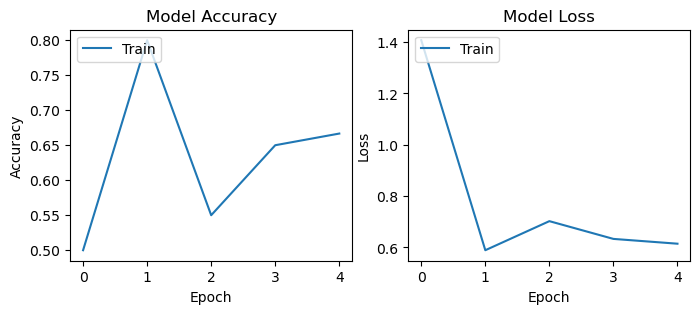

In [84]:
# Accuracy and Loss
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### (ii) ROC Curves and AUC

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


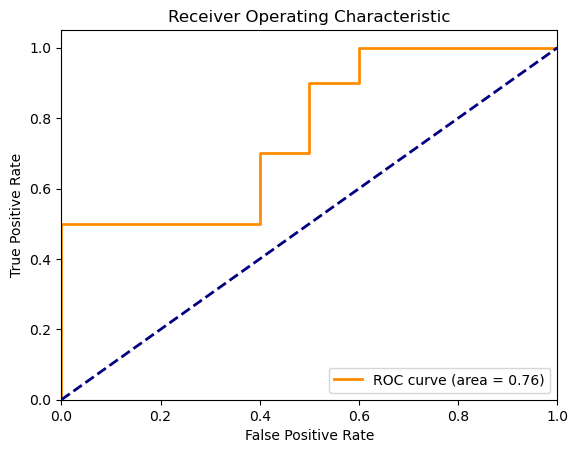

In [85]:
# Predict the probabilities for the positive class
y_pred_probs = model.predict(valid_videos)
y_score = y_pred_probs[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(valid_labels, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 2. Model Analysis

### 2.1 Confusion matrix (TF vs. TN vs. FP vs. FN) 
Result Evaluation  - Bias towards Classifying Videos to Normal Class

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Prediction: Crash 0.73677665
Actual:     Crash 000131.mp4

Prediction: Crash 0.7027431
Actual:     Crash 000882.mp4

Prediction: Crash 0.7849224
Actual:     Crash 002414.mp4

Prediction: Crash 0.7793461
Actual:     Crash 001471.mp4

Prediction: Crash 0.7327699
Actual:     Crash 000953.mp4

Prediction: Crash 0.871113
Actual:     Crash 001084.mp4

Prediction: Crash 0.88922936
Actual:     Crash 002233.mp4

Prediction: Normal 0.5837151
Actual:     Crash 002873.mp4

Prediction: Crash 0.77292335
Actual:     Normal 001443.mp4

Prediction: Crash 0.7628753
Actual:     Normal 000351.mp4

Prediction: Normal 0.7105624
Actual:     Normal 000430.mp4

Prediction: Normal 0.6247276
Actual:     Normal 000778.mp4

Prediction: Normal 0.62572396
Actual:     Normal 000467.mp4

Prediction: Normal 0.62382233
Actual:     Normal 001410.mp4

Prediction: Normal 0.60009825
Actual:     Normal 000748.mp4

Prediction: Normal 0.67131996
Actual:     Normal 001302.mp4

13 videos out o

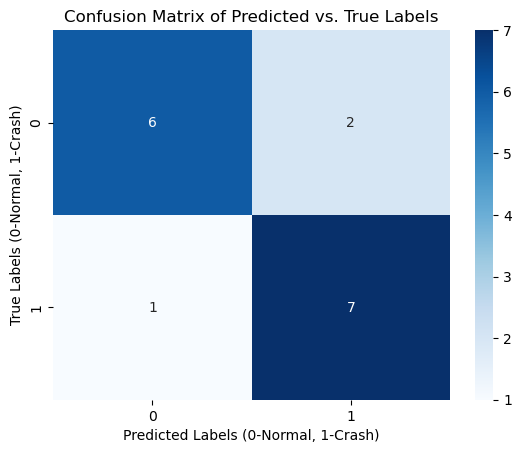

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate 16 testing videos

model_predict_test = model.predict(testloader)

# Inspect Test Results

pred = []
normal_count = 0
misclassified_indicies = []

for i in range(16):
    crash_conf = model_predict_test[i][0]
    normal_conf = model_predict_test[i][1]
    if (crash_conf > normal_conf):
        print("Prediction: Crash", crash_conf)
        pred.append(1)
    else:
        print("Prediction: Normal", normal_conf)
        pred.append(0)
        normal_count += 1
    if (i < 8):
        print("Actual:     Crash", test_normal[i]+".mp4")
    else:
        print("Actual:     Normal", test_crash[abs(i-8)]+".mp4")
    print()
print(str(abs(len(test_labels)-normal_count)) + " videos out of 16 videos are classified as Crash")
print(str(normal_count) + " videos out of 16 videos are classified as Normal")

true = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]

cm = confusion_matrix(true, pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels (0-Normal, 1-Crash)')
plt.ylabel('True Labels (0-Normal, 1-Crash)')
plt.title('Confusion Matrix of Predicted vs. True Labels')
plt.show()

### 2.2 Feature analysis (Weight and Bias)

weights,biases = model.layers[-1].get_weights()<br>这行代码extract了最后一层的features<br>一共64个feature，两个class

In [87]:
# # If interested in knowing what techniques are used for each layer
# for layer in model.layers:
#     print(layer.__class__.__name__)

In [88]:
# Extract Weights and Biases from the Two Dense Layers
weights,biases = model.layers[-1].get_weights()
# print(np.array(weights.shape)) # [64  2], 64 embedding layers with 2 classes

# Biases
print("Biases")
print(np.array(biases))  # [-0.00016644  0.00016644]

# Weights
print("\nWeights")
pd.DataFrame(weights)

Biases
[-0.00035129  0.00035129]

Weights


,0,1
0,-0.135598,0.163245
1,0.096174,-0.237513
2,-0.238606,0.284001
3,-0.170035,-0.244510
4,0.138861,-0.067612
...,...,...
59,0.123018,0.140835
60,0.238139,-0.107917
61,0.104432,-0.259904
62,0.240964,-0.071512


In [89]:
print(max(pd.DataFrame(weights).iloc[:,0]), min(pd.DataFrame(weights).iloc[:,0]), \
      max(pd.DataFrame(weights).iloc[:,1]), min(pd.DataFrame(weights).iloc[:,1]))

0.2991706132888794 -0.3011588454246521 0.2924739420413971 -0.2965048849582672


### (i) Overall weights and biases （Weight histogram）

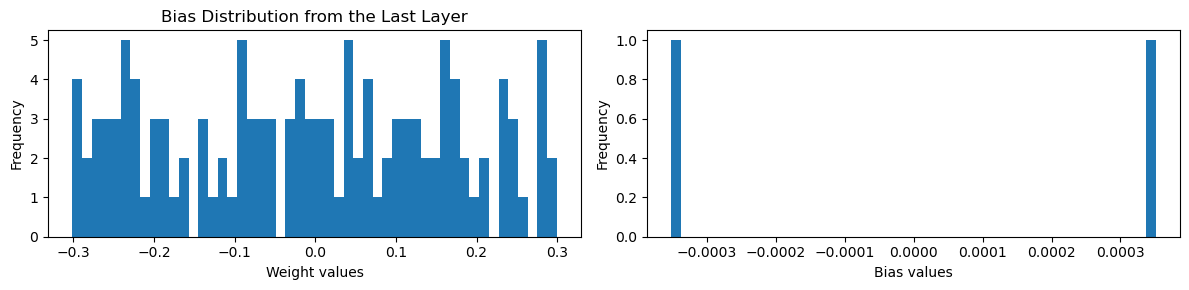

In [90]:
# Plotting

plt.figure(figsize=(12, 3))

# Weight Distribution
plt.subplot(1, 2, 1)
plt.title("Weight Distribution of the Last Layer")
plt.hist(weights.flatten(), bins=50)
plt.xlabel("Weight values")
plt.ylabel("Frequency")

# Bias Distribution
plt.title("Bias Distribution from the Last Layer")
plt.subplot(1, 2, 2)
plt.hist(biases.flatten(), bins=50)
plt.xlabel("Bias values")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### (ii) For each feature, does it contribute POSITIVELY or NEGATIVELY to each of the classification? （LIME explainer）

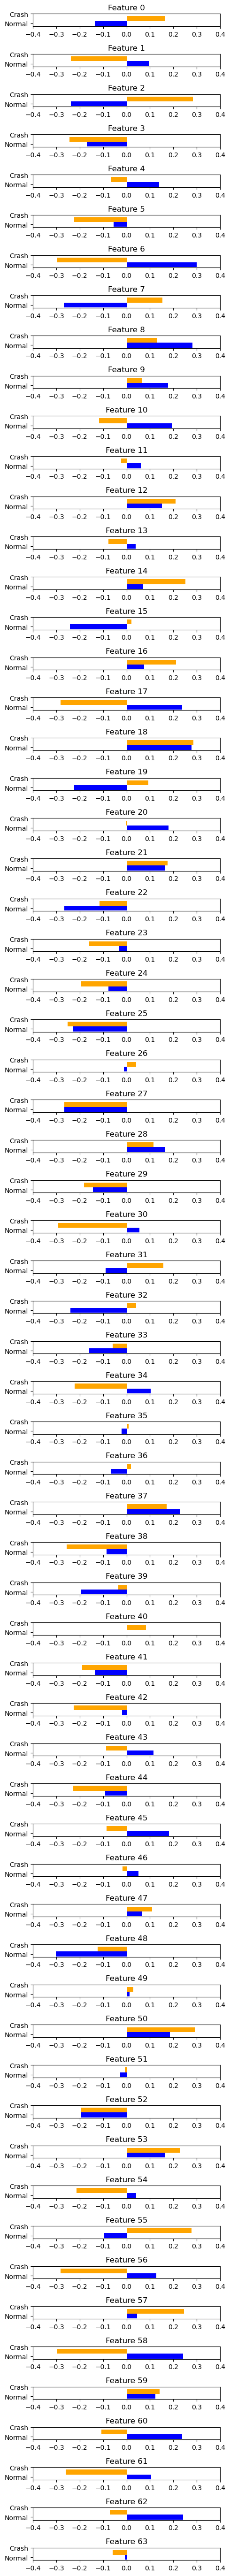

In [91]:
# Number of features
num_features = weights.shape[0]

# Prepare boundaries for each graph
bound = math.ceil(max(abs(np.max(weights)), abs(np.min(weights)))*10)/10

# Plotting 

fig, axs = plt.subplots(num_features, 1, figsize=(5, 55))  #Adjust size as needed

for i in range(num_features):
    index = np.arange(2)
    bar_height = 0.5
    offset = np.array([0, bar_height])
    axs[i].barh(index-offset, weights[i, :], bar_height, color=['blue', 'orange'])
    axs[i].set_yticks(index)
    axs[i].set_yticklabels(['Normal', 'Crash'])
    axs[i].set_title('Feature {}'.format(i))

    # Setting x-axis 
    axs[i].set_xlim([-bound, bound])

plt.tight_layout()
plt.show()

### What can we tell?



### For each feature, which feature does it tend more to contribute to? [Graphs of Comparison]

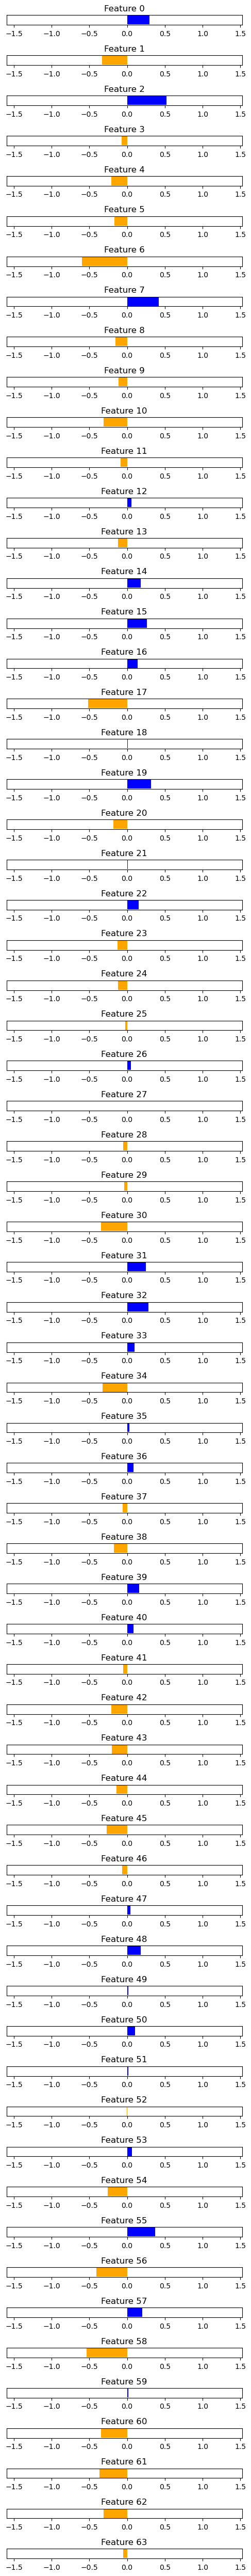

In [92]:
# Calculate the differences: Crash - Normal
differences = weights[:, 1] - weights[:, 0]

# Number of features
num_features = weights.shape[0]

# Set bound
bound = math.ceil(np.max(differences)*10)/10

# Creating the plot
fig, axs = plt.subplots(64, 1, figsize=(5, 50))  # Adjust size as needed

for i in range(num_features):
    axs[i].barh(0, differences[i], color='blue' if differences[i] >= 0 else 'orange')
    axs[i].set_title('Feature {}'.format(i))
    axs[i].set_xlim([differences.min() - 1, differences.max() + 1])
    axs[i].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

### What can we tell?



### (iii) What if we use only a few selected features in a selected layer?

我在这里提取出我感兴趣的indicies<br>然后设置了感兴趣的layer_index<br>看看如果重新train model的时候（在那个特定的layer只跑特定的weights），会不会出现什么神奇的结果

In [93]:
# def gelu(x):
#     return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

In [94]:
# Separate the `differences` into those that contribute more to the normal class or crash class
tend_normal = abs(differences[differences<0])
tend_crash = abs(differences[differences>0])

# Select a number
x = 2

# Select the top x features' indicies that contribute more to either of the class
tend_normal_top_x_indices = np.argsort(tend_normal)[-x:][::-1]
tend_crash_top_x_indices = np.argsort(tend_crash)[-x:][::-1]
selected_weights_indices = np.concatenate((tend_normal_top_x_indices, tend_crash_top_x_indices))
# selected_weights = weights[selected_weights_indices]

# Biases
# biases

# I have the biases and the weight matrix for binary classification. 
# How should I apply the GELU with those information?

In [95]:
from tensorflow.keras.callbacks import Callback

class ApplyMaskCallback(Callback):
    def __init__(self, mask, layer_index):
        super().__init__()
        self.mask = mask
        self.layer_index = layer_index

    def on_batch_end(self, batch, logs=None):
        weights = self.model.layers[self.layer_index].get_weights()
        weights[0] *= self.mask  # Apply mask to weights, not biases
        self.model.layers[self.layer_index].set_weights(weights)

layer_index = -1 # last layer
mask = np.ones_like(model.layers[layer_index].get_weights()[0])
mask = np.zeros((EMBED_DIM, NUM_CLASSES))
mask[selected_weights_indices, :] = 1
callback = ApplyMaskCallback(mask, layer_index=layer_index)
callback

In [96]:
model_new, history_new = run_experiment(callback=callback)

Callbacks being passed to model.fit(): <__main__.ApplyMaskCallback object at 0x29a7fe590>
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 11s/step - accuracy: 0.4113 - loss: 1.6340 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7790 - val_top-5-accuracy: 1.0000
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 125s 16s/step - accuracy: 0.7896 - loss: 0.5284 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.8784 - val_top-5-accuracy: 1.0000
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 12s/step - accuracy: 0.2752 - loss: 1.0276 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7669 - val_top-5-accuracy: 1.0000
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.1876 - loss: 0.8365 - top-5-accuracy: 1.0000 - val_accuracy: 0.6000 - val_loss: 0.6689 - val_top-5-accuracy: 1.0000
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - accuracy: 0.3900 - loss: 0.6570 - top-5-accuracy: 1.0000 - val_accuracy: 0.6000 - val_loss: 0.6557 - val_top-5-accuracy: 1.0000


In [97]:
weights_new,biases_new = model_new.layers[-1].get_weights()

**Why using callback?**

Selectively zero out weights in a specific layer (last layer) of a neural network during training

Allowing the model to only learn using the unmasked weights during that last layer. 

This is useful for testing the impact of specific features or weights on model performance.

### (iv) t_SNE

In [98]:
def plot_clustering(X_red, labels, title=None):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    for i, label in enumerate(unique_labels):
        plt.scatter(X_red[labels == label, 0], X_red[labels == label, 1], color=colors(i), label=f'Cluster {label}')

    plt.title(title if title else 'Cluster Plot')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [99]:
model_feature = Model(inputs=model.input, outputs=model.layers[-2].output)
features = model_feature.predict(valid_videos)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/var/folders/4l/37tzg18n5y95_8hdk84rvt0r0000gn/T/ipykernel_70261/1230232631.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


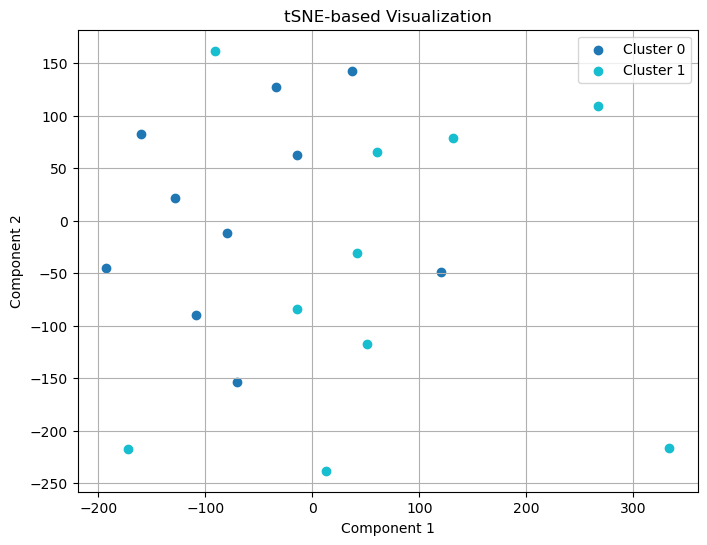

In [100]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=300, learning_rate=200)
X_tsne = tsne.fit_transform(features)

plot_clustering(X_tsne, valid_labels, 'tSNE-based Visualization')

### (v) Layer Weight and Activation Animations

In [ ]:
class WeightsHistory(Callback):
    def __init__(self):
        super().__init__()
        self.weights_over_time = []

    def on_train_begin(self, logs=None):
        self.weights_over_time.clear()  # Clear the list at the start of training
        print("on_train_begin called - WeightsHistory callback is active.")

    def on_epoch_end(self, epoch, logs=None):
        weights, _ = self.model.layers[-1].get_weights()
        self.weights_over_time.append(weights.copy())
        print(f"Epoch {epoch}: Weights saved.")


# Initialize the custom callback
weights_history_callback = WeightsHistory()

# Pass both callbacks to the `run_experiment` function
model, history = run_experiment(callback=weights_history_callback)


In [ ]:
weights_over_time = weights_history_callback.weights_over_time
print("Weights over time:", weights_over_time)

### 2.4 Multi-Head Attention

In [ ]:
# Here are the indicies of the misclassified test videos
misclassified = []
for i in range(len(pred)):
    if pred[i] != true[i]:
        misclassified.append(i)
misclassified

In [ ]:
# How do we visualize it?

"""

Attention Scores Calculation: 
The attention mechanism calculates scores by performing a dot product of the query with all keys for each head.
These scores determine how much focus (or attention) should be given to other parts of the input.

Aggregated Information: Each element in the output tensor represents an aggregation of information 
from other parts of the input, weighted by the calculated attention scores.


You can aggregate attention weights across different frames to see 
if there's a temporal pattern in how the model attends to different regions of the video.

Generate heatmaps for individual frames 
or average them across a sequence to visually 
represent where the model is "looking."

"""

# attention.shape  # (1, 1536, 64) 
# (Batch Size (1), Num of Tokens (1526), Embedding Dimension (64))

In [ ]:
""" REFERENCE

EMBED_DIM = 64
PATCH_SIZE = 8,8,8
INPUT_SHAPE = (50, 128, 128, 1)
NUM_HEADS = 6

"""

# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function

def preprocess_frames(frames: tf.Tensor):
    """Preprocess the frames tensors for prediction."""
    frames = tf.image.convert_image_dtype(
        frames[..., tf.newaxis],
        tf.float32,
    )
    return frames

# Define the model up to the attention layer
# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function

inputs = layers.Input(shape=INPUT_SHAPE)
tubelet_embedder = TubeletEmbedding(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE)
patches = tubelet_embedder(inputs)
positional_encoder = PositionalEncoder(embed_dim=EMBED_DIM)
encoded_patches = positional_encoder(patches)
x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)
attention_output = multi_head_attention(x, x)

# Model Building

model = Model(inputs=inputs, outputs=attention_output)

# Assuming test_videos[0] is a numpy array and needs to be converted to a TensorFlow tensor

video_tensor = tf.convert_to_tensor(test_videos[0], dtype=tf.float32)
preprocessed_video = preprocess_frames(video_tensor)
preprocessed_video = tf.expand_dims(preprocessed_video, axis=0)
attention = model.predict(preprocessed_video)

print(attention)